# Ensemble Learning Exercise

## 1. Implementing Random Forest From Scratch (30 points)
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your model will handle **continuous input and output**. 

1.1. Compelete the skeleton class below (you should use scikit-learn's `DecisionTreeRegressor` model that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `n_features` is the size of features to sample. This can be a natrual number > 0, or a ratio of the features as a number in range (0,1]
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  

1.2. The `predict` function will use mean of the target values of the trees. The result is a vector of predictions matching the number of rows in `X`.

1.3. The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

1.4. To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
 


## Load data and import stuff

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the Boston Housing dataset
boston = load_boston()

# Convert the dataset to a DataFrame
X = pd.DataFrame(boston.data, columns=boston.feature_names)

# Add the target variable (median value of the houses) to the DataFrame
y = pd.Series(boston.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


## IMPLEMENT FOREST

In [7]:

class TreeEnsemble():
    def __init__(self, X, y, n_trees, sample_sz, n_features, min_leaf):
        
        self.samples = X
        self.targets = y
        self.n_trees = n_trees
        
        self.sample_sz =  sample_sz
        if isinstance(n_features,float): 
            self.n_features =  int(n_features *  X.shape[1])
        else:
            self.n_features = n_features
        self.min_leaf = min_leaf
        self.trees = [] # List holding all the trees.
        self.oob_scores = [] # List holding OOB score for each tree, used to calculate oob_mse.
        self.create_trees()
    def create_trees(self):
        
        for i in range(self.n_trees): # loop creating trees n_trees times

            # partition data by rows and features (in bag data)
            ib_X,ib_y,oob_X,oob_y = self.bootstrap() # ib = in_bag
            
            # generate tree
            tree = DecisionTreeRegressor(min_samples_leaf=self.min_leaf)
            tree.fit(ib_X, ib_y)
            self.trees.append(tree)
            
            # calculate oob_error and append oob_scores list
            self.oob_scores.append(self.calculate_oob_error(tree,oob_X,oob_y))
            
    def calculate_oob_error(self,tree,X,y):
        y_pred = tree.predict(X)
        return np.mean((y_pred - y)**2)
        
    def bootstrap(self): # generates bootstrapped data

            rows = np.random.choice(self.samples.index, self.sample_sz, replace=False) # Change replace = True for repetiton of samples
            cols =  np.random.choice(self.samples.shape[1], self.n_features, replace=False)
            ib_y = self.targets[rows] # ib stands for in_bag
            ib_X =  self.samples.loc[rows]
            ib_X = ib_X.iloc[:,cols]
            oob_X = self.samples.drop(rows).iloc[:,cols]
            oob_y = self.targets.drop(rows,axis=0)

            return ib_X ,ib_y, oob_X,oob_y
        
    def predict(self, X):    
        
        predictions = []
        for i in range(self.n_trees):
            predictions.append(self.trees[i].predict(X[self.trees[i].feature_names_in_]))
        return np.mean(predictions, axis=0)
  
    def oob_mse(self):
        return np.mean(self.oob_scores)
 

In [23]:
best_mse = np.inf
best_hyper = []
for n in [15,50,75,100]:
  for sz in [50,100]:
    for n_features in np.linspace(0.1,0.5,5):
      for min_leaf in [1,5]:
        forest = TreeEnsemble(X, y, n, sz,n_features, min_leaf)
        mse = forest.oob_mse()
        if best_mse > mse:
          best_mse = mse
          best_hyper = [n,sz,n_features,min_leaf]

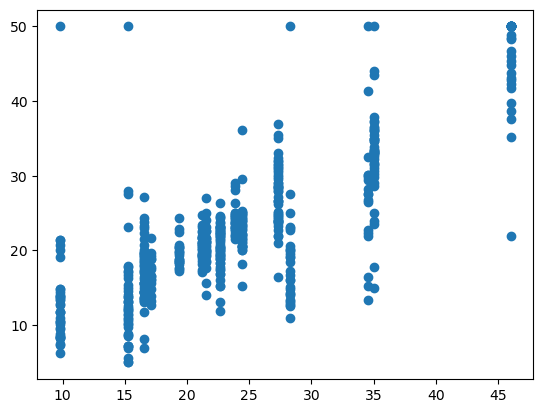

In [ ]:
forest = TreeEnsemble(X,y,*best_hyper)
y_hat = forest.predict(X)  # forest is the chosen model
plt.scatter(y_hat, y);

In [ ]:
forest = TreeEnsemble(X,y,*best_hyper)
y_hat = forest.predict(X)  # forest is the chosen model
plt.scatter(y_hat, y)
best_hyper

## 2. Implementing AdaBoost From Scratch (30 points)


2.1.   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).

2.2.   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:

2.2.1. For the base weak learners, use any classifier you want (check different types with different configuration, keep them simple = Weak). 

2.2.2. Split the sample set into train and test sets.

2.2.3 Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?





In [ ]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

## 3. Boosting Trees from Scratch (40 points)
1. Use the scikit-learn's DecisionTreeRegressor (again :) with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
2. Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
3. Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
4. Add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.